In [1]:
from src.tensor import Tensor
import src.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from mnist import MNIST
np.set_printoptions(suppress=True)

In [2]:
mndata = MNIST('./mnist_dataset/')
mndata.gz = True
training, test = mndata.load_training(), mndata.load_testing()

In [3]:
X = np.array(training[0] + test[0], dtype=float)
Y = np.array(list(training[1]) + list(test[1]), dtype=int)

# Scale down pixels from 0-255 to 0-1
X = X / 255.0

# OneHot label vectors
one_hot = np.zeros((Y.size, 10)) # (70000, 10)
one_hot[np.arange(Y.size), Y] = 1
Y = one_hot

In [4]:
# Split
n = len(X)
tr, d = int(n*0.8), int(n*0.9)
Xtr, Xdev, Xte = Tensor(X[:tr]), Tensor(X[tr:d]), Tensor(X[d:])
Ytr, Ydev, Yte = Tensor(Y[:tr]), Tensor(Y[tr:d]), Tensor(Y[d:])
print(f'Sizes: train={len(Xtr)}, val={len(Xdev)}, test={len(Xte)}')

Sizes: train=56000, val=7000, test=7000


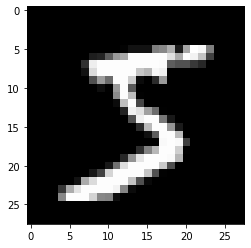

In [5]:
# Visualize X
img = np.array(Xtr[0].tolist())
plt.imshow(img.reshape(28, 28),cmap='gray')
plt.show()

In [6]:
# Multinomial sampling with replacement
rng = np.random.default_rng(seed=1)
def draw_batch(batch_size): 
    draw = lambda: int(rng.random() * len(Xtr))
    batch = [draw() for _ in range(batch_size)]
    return Xtr[batch], Ytr[batch]

def accuracy(split):
    x, y = {'train': (Xtr, Ytr), 'dev': (Xdev, Ydev), 'test': (Xte, Yte)}[split]
    global mlp
    x = mlp(x) # (7000, 10)
    correct = (x.data.argmax(1) == y.data.argmax(1)).sum()
    acc = (correct / len(x)) * 100
    print(f'{split}-accuracy: {acc:.2f}%')

In [7]:
mlp = nn.Sequential((
    nn.Linear(784, 784), nn.BatchNorm(784),
    nn.Relu(),
    nn.Linear(784, 784), nn.BatchNorm(784),
    nn.Relu(),
    nn.Linear(784, 512), nn.BatchNorm(512),
    nn.Relu(),
    nn.Linear(512, 256), nn.BatchNorm(256),
    nn.Relu(),
    nn.Linear(256, 10),
    nn.Softmax()
))
losses = []
dev_losses = []

In [18]:
steps = 300
batch_size = 32
lr = 0.01
breakpoint = -1
for i in range(steps):
    x, y = draw_batch(batch_size)
    out = mlp(x)

    loss = nn.nlll(out, y, reduction='mean')
    loss.backward()

    mlp.optimize(lr=lr)
    mlp.zero_grad()

    loss = loss.data.item()
    losses.append(loss)
    dev_loss = nn.nlll(mlp(Xdev), Ydev, reduction='mean').data.item()
    dev_losses.append(dev_loss)
    print(f'Step {i}: train={loss}, val={dev_loss}')

plt.plot(losses, label='train')
plt.plot(dev_losses, label='dev')
plt.show()

Step 0: train=0.19189498734801694, val=0.4271812362644015
Step 1: train=0.23871917324078828, val=0.42940574129498565
Step 2: train=0.06943784719478306, val=0.43073367107005744
Step 3: train=0.4381960569849998, val=0.44063551255576766
Step 4: train=1.1975220005086642, val=0.4312461078965239
Step 5: train=0.1997508926397552, val=0.42895750368658825
Step 6: train=0.17589404339181344, val=0.4277060567392156
Step 7: train=0.5222461831289289, val=0.4226539897932029
Step 8: train=0.19752502693554685, val=0.4306737349137032
Step 9: train=0.1828958829996673, val=0.4340309284337929
Step 10: train=0.5543107461438485, val=0.4243115074745314
Step 11: train=0.5764143736474057, val=0.4256887841649697
Step 12: train=0.7438861690452843, val=0.42974508446311616
Step 13: train=0.377169956762954, val=0.42869753686089035
Step 14: train=0.7157149074430172, val=0.42438165600150307
Step 15: train=0.5163576382165512, val=0.43067520115602975
Step 16: train=0.15444109501885356, val=0.43064248414726974
Step 17: t

KeyboardInterrupt: 

In [19]:
accuracy('dev')

dev-accuracy: 88.54%


In [20]:
mlp.inference()
accuracy('test')

test-accuracy: 90.40%
